<a href="https://colab.research.google.com/github/musayevf/Basic-Progress-Bar/blob/main/ANN_Project_Traffic_Sign_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Importing Necessary Libraries**

In [14]:
from google.colab import drive
import os, cv2
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.models import Model
from tensorflow.keras.layers import GlobalAveragePooling2D

**Importing Data from Google Colab**

In [2]:
#Google Drive
drive.mount('/content/drive')

#path in colab
data_path = '/content/drive/My Drive/Colab Notebooks'

# contents
data_contents = os.listdir(data_path)

print(data_contents)

Mounted at /content/drive
['test.p', 'train.p', 'valid.p', 'German Traffic Sign Classification', 'UNET Model.ipynb', 'ANN Project Traffic Sign Classification']


**Since the Data is in Pickle Format, Loading Pickle Files in Google Colab**

In [3]:
train_pickle_path = '/content/drive/My Drive/Colab Notebooks/train.p'
validation_pickle_path = '/content/drive/My Drive/Colab Notebooks/valid.p'
test_pickle_path = '/content/drive/My Drive/Colab Notebooks/test.p'

#load pickle
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Load pickle files
train_data = load_pickle(train_pickle_path)
validation_data = load_pickle(validation_pickle_path)
test_data = load_pickle(test_pickle_path)

print("Number of samples in train data:", len(train_data))
print("Number of samples in validation data:", len(validation_data))
print("Number of samples in test data:", len(test_data))

Number of samples in train data: 4
Number of samples in validation data: 4
Number of samples in test data: 4


**Inspecting Data**

In [5]:
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

pickle_path = '/content/drive/My Drive/Colab Notebooks/train.p'

data_dict = load_pickle(pickle_path)
pd.DataFrame()

#Access image data
print(data_dict.keys())

for key, value in data_dict.items():
    print(f"Key: {key}, Type: {type(value)}, Shape/Length: {getattr(value, 'shape', len(value))}")

dict_keys(['coords', 'labels', 'features', 'sizes'])
Key: coords, Type: <class 'numpy.ndarray'>, Shape/Length: (34799, 4)
Key: labels, Type: <class 'numpy.ndarray'>, Shape/Length: (34799,)
Key: features, Type: <class 'numpy.ndarray'>, Shape/Length: (34799, 32, 32, 3)
Key: sizes, Type: <class 'numpy.ndarray'>, Shape/Length: (34799, 2)


**Structured data from a dictionary loaded from a pickle file into a pandas DataFrame, processes it for analysis, and visualizes the distribution of labels using a bar graph**

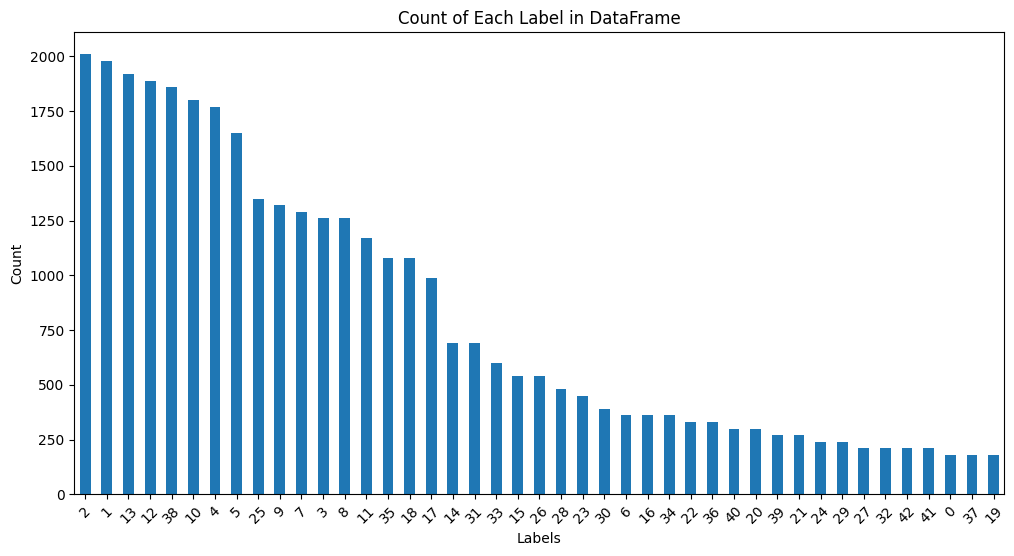

In [6]:
df_data = {}

# Add the labels directly as they are 1D
df_data['labels'] = data_dict['labels']

coords = data_dict['coords']
sizes = data_dict['sizes']

for i in range(coords.shape[1]):
    df_data[f'coords_{i}'] = coords[:, i]

for i in range(sizes.shape[1]):
    df_data[f'sizes_{i}'] = sizes[:, i]

# Convert to DataFrame
df = pd.DataFrame(df_data)

# If you need to include features, they need special handling because they are 3D arrays per sample
# One way to handle this is to flatten each image to a 1D array or keep as an array column
df['features'] = [f.flatten() for f in data_dict['features']]  # Flatten each image

# Display the DataFrame
# Step 1: Count occurrences of each label
label_counts = df['labels'].value_counts()
plt.figure(figsize=(12, 6))

# Step 2: Plot the bar graph
label_counts.plot(kind='bar')

# Customize the plot
plt.xlabel('Labels')
plt.ylabel('Count')
plt.title('Count of Each Label in DataFrame')
plt.xticks(rotation=45)

# Show the plot
plt.show()

**Visualize an image stored as a flattened array in a pandas DataFrame**

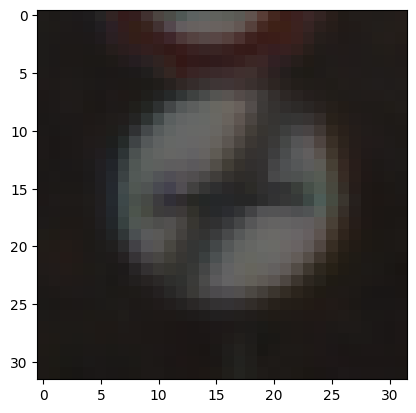

In [9]:
# Example: Convert the first image back to 32x32x3 for visualization
first_image_flattened = df['features'][3]
first_image = np.array(first_image_flattened).reshape(32, 32, 3)

plt.imshow(first_image)
plt.show()

**Image data for training a machine learning model using TensorFlow. It converts structured data from a dictionary into a pandas DataFrame, normalizes and flattens the images, and one-hot encodes the labels. The data is then split into training and validation sets and reshaped back to the original image dimensions (32x32x3)**

**Applying Data Augmentation**

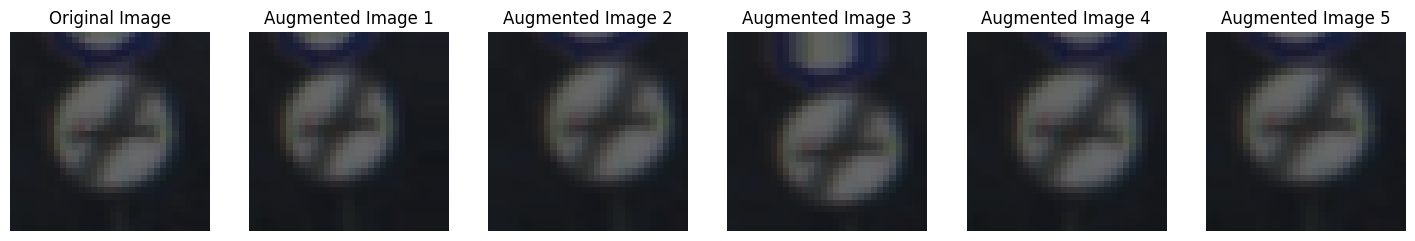

In [11]:
# Define the data augmentation generator
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)

# Prepare a batch of one image for augmentation
sample_image = np.expand_dims(first_image, 0)

# Generate augmented images
augmented_images = [datagen.flow(sample_image, batch_size=1)[0].astype(np.uint8)[0] for _ in range(5)]

# Plot the original and augmented images
fig, axes = plt.subplots(1, 6, figsize=(18, 3))
axes[0].imshow(cv2.cvtColor(sample_image[0], cv2.COLOR_BGR2RGB))
axes[0].set_title('Original Image')
axes[0].axis('off')

for i, img in enumerate(augmented_images):
    axes[i + 1].imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    axes[i + 1].set_title(f'Augmented Image {i + 1}')
    axes[i + 1].axis('off')

plt.show()

**Checking dimensions of training and validation data**

In [13]:
# Initialize a dictionary to store the DataFrame-ready data
df_data = {}

# Add the labels directly as they are 1D
df_data['labels'] = data_dict['labels']

# For coords and sizes, convert each sub-array into separate columns
coords = data_dict['coords']
sizes = data_dict['sizes']

# Adding coord columns
for i in range(coords.shape[1]):
    df_data[f'coords_{i}'] = coords[:, i]

# Adding size columns
for i in range(sizes.shape[1]):
    df_data[f'sizes_{i}'] = sizes[:, i]

# Convert to DataFrame
df = pd.DataFrame(df_data)

# Flatten each image and normalize pixel values
df['features'] = [f.flatten() / 255.0 for f in data_dict['features']]  # Normalize each image

# Convert DataFrame features to numpy array
X = np.stack(df['features'].values)
y = df['labels'].values

# Convert labels to categorical
num_classes = 43
y = tf.keras.utils.to_categorical(y, num_classes)

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Reshape X back to original image dimensions (32x32x3)
X_train = X_train.reshape(-1, 32, 32, 3)
X_val = X_val.reshape(-1, 32, 32, 3)

print(f'Training data shape: {X_train.shape}')
print(f'Validation data shape: {X_val.shape}')


Training data shape: (27839, 32, 32, 3)
Validation data shape: (6960, 32, 32, 3)


**Trains, and evaluates pre-trained VGG16 model using TensorFlow and Keras. The model includes convolutional, max-pooling, flattening, and dense layers, compiled with the Adam optimizer and categorical cross-entropy loss. Data augmentation is applied to the training data to improve generalization. The model is trained with early stopping to avoid overfitting, then evaluated on the validation set to obtain accuracy. Finally, the training and validation accuracy over epochs are plotted to visualize performance.**

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step
Epoch 1/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 411s 943ms/step - accuracy: 0.2456 - loss: 2.7095 - val_accuracy: 0.4874 - val_loss: 1.5911
Epoch 2/30
  1/434 ━━━━━━━━━━━━━━━━━━━━ 4:33 632ms/step - accuracy: 0.5000 - loss: 1.6650

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


434/434 ━━━━━━━━━━━━━━━━━━━━ 83s 189ms/step - accuracy: 0.5000 - loss: 1.6650 - val_accuracy: 0.4884 - val_loss: 1.5891
Epoch 3/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 407s 937ms/step - accuracy: 0.4527 - loss: 1.7241 - val_accuracy: 0.5901 - val_loss: 1.3030
Epoch 4/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 79s 180ms/step - accuracy: 0.3125 - loss: 2.0226 - val_accuracy: 0.5918 - val_loss: 1.3067
Epoch 5/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 422s 934ms/step - accuracy: 0.5177 - loss: 1.4932 - val_accuracy: 0.6411 - val_loss: 1.1528
Epoch 6/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 83s 189ms/step - accuracy: 0.6250 - loss: 1.1780 - val_accuracy: 0.6398 - val_loss: 1.1503
Epoch 7/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 408s 940ms/step - accuracy: 0.5626 - loss: 1.3423 - val_accuracy: 0.6665 - val_loss: 1.0439
Epoch 8/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 79s 181ms/step - accuracy: 0.6406 - loss: 1.2790 - val_accuracy: 0.6704 - val_loss: 1.0382
Epoch 9/30
434/434 ━━━━━━━━━━━━━━━━━━━━ 405s 932ms/step - accuracy: 0.5861 - loss: 1.2621 -

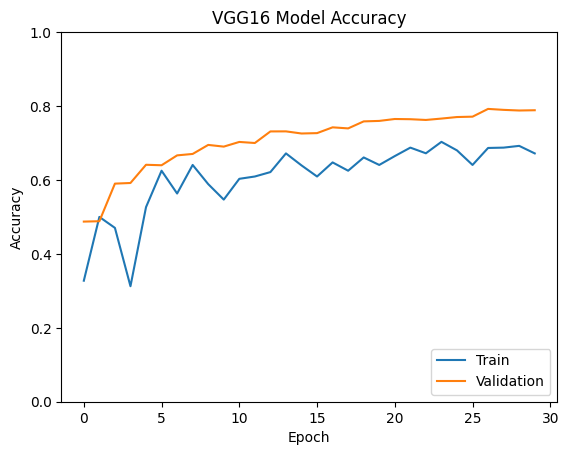

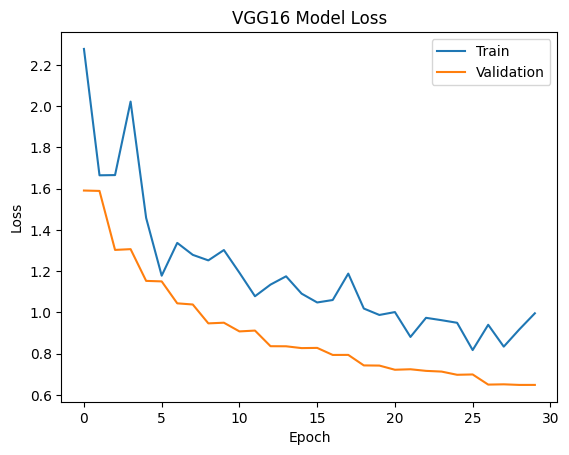

In [17]:
# VGG16 Model
def build_vgg16(input_shape, num_classes):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False  # Freeze the base model initially

    model = Sequential()
    model.add(base_model)
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (32, 32, 3)
num_classes = 43

vgg16_model = build_vgg16(input_shape, num_classes)
vgg16_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)
datagen.fit(X_train)

# Early stopping
batch_size = 64
epochs = 30

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_vgg16 = vgg16_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[early_stopping]
)

# Evaluate the model
test_loss, test_accuracy = vgg16_model.evaluate(X_val, y_val, verbose=2)
print(f'Test accuracy: {test_accuracy}')

# Plot accuracy
plt.plot(history_vgg16.history['accuracy'], label='Train')
plt.plot(history_vgg16.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('VGG16 Model Accuracy')
plt.show()

# Plot loss
plt.plot(history_vgg16.history['loss'], label='Train')
plt.plot(history_vgg16.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('VGG16 Model Loss')
plt.show()

**It creates a figure with two subplots: the first shows accuracy over epochs for both training and validation sets, and the second shows the corresponding loss values. Titles, labels, and legends are added to both plots for clarity.**

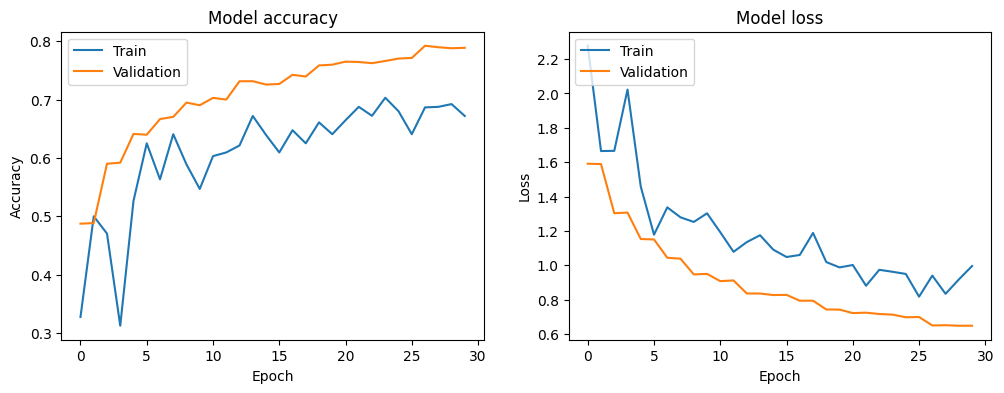

In [18]:
# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_vgg16.history['accuracy'])
plt.plot(history_vgg16.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history_vgg16.history['loss'])
plt.plot(history_vgg16.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

Explanation:


1.   Training and Validation Accuracy and Loss: Plots to compare the training and validation accuracy and loss over epochs.
2.   Filters Visualization: Visualizes the filters from the first convolutional layer.
3.  Feature Maps: Visualizes the feature maps generated by the convolutional layers for a sample image.



**Identifies and visualizes misclassified samples from the validation set. Predictions are made on the validation data, and the predicted classes are compared with the true classes.**

218/218 ━━━━━━━━━━━━━━━━━━━━ 83s 379ms/step


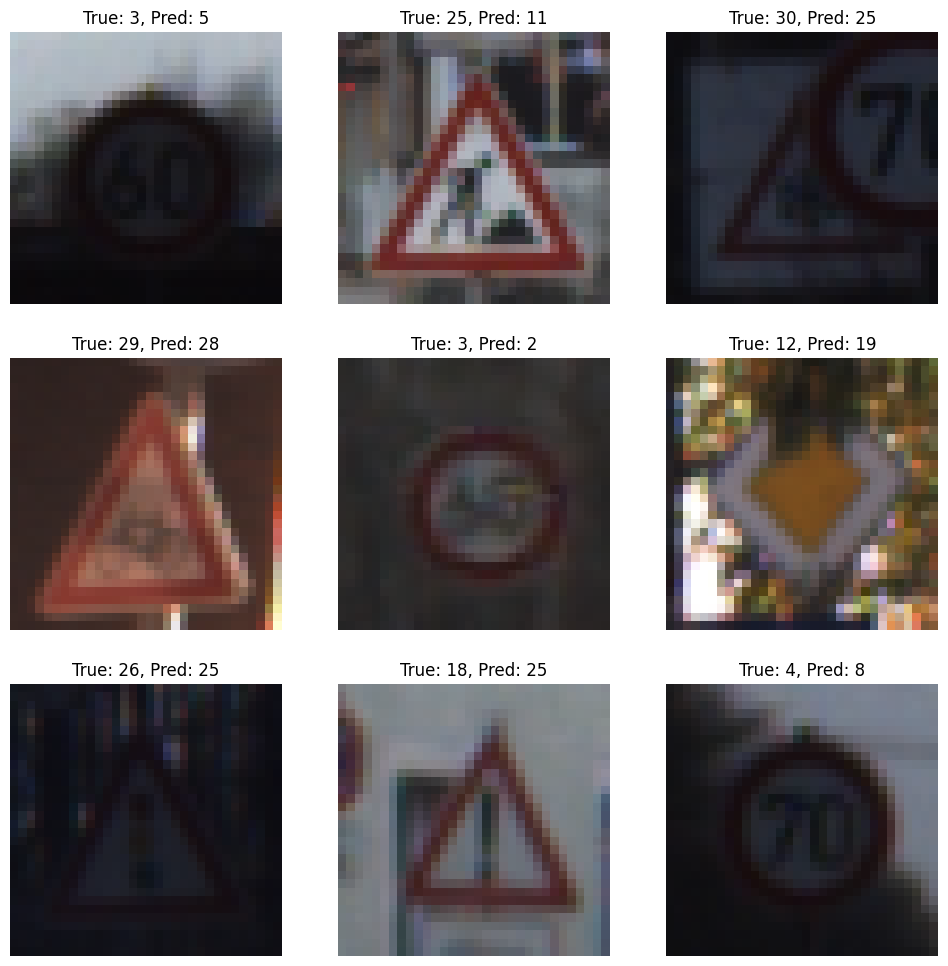

In [19]:
# Predict on the validation set
y_pred = vgg16_model.predict(X_val)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_val, axis=1)

# Identify misclassified samples
misclassified_indices = np.where(y_pred_classes != y_true)[0]

# Plot some misclassified samples
plt.figure(figsize=(12, 12))
for i, idx in enumerate(misclassified_indices[:9]):
    plt.subplot(3, 3, i+1)
    plt.imshow(X_val[idx].reshape(32, 32, 3))
    plt.title(f"True: {y_true[idx]}, Pred: {y_pred_classes[idx]}")
    plt.axis('off')
plt.show()


**Visualizes the confusion matrix for the validation set predictions. The confusion matrix is calculated by comparing the true labels with the predicted classes.**

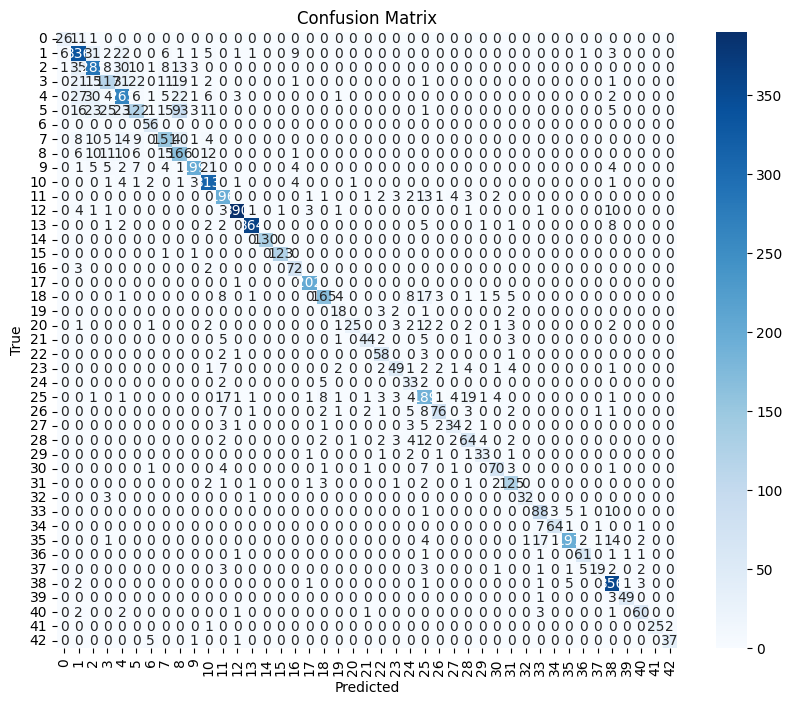

In [20]:
conf_matrix = confusion_matrix(y_true, y_pred_classes)


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(num_classes), yticklabels=range(num_classes))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# AlexNet and DenseNet Models

**Code builds and trains an AlexNet-like convolutional neural network (CNN) adapted for 32x32 images. The model includes multiple convolutional and max-pooling layers followed by dense layers with ReLU activations and a softmax output layer for classification. It is compiled with the Adam optimizer and categorical cross-entropy loss, and trained using data augmentation and early stopping to prevent overfitting. The training process involves augmenting the data and fitting the model to the training data while validating on a separate validation set**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


543/543 ━━━━━━━━━━━━━━━━━━━━ 75s 129ms/step - accuracy: 0.2525 - loss: 2.6756 - val_accuracy: 0.7320 - val_loss: 0.9586
Epoch 2/30
  1/543 ━━━━━━━━━━━━━━━━━━━━ 37s 70ms/step - accuracy: 0.7344 - loss: 0.8959

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


543/543 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.7344 - loss: 0.8959 - val_accuracy: 0.7170 - val_loss: 0.9815
Epoch 3/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 66s 122ms/step - accuracy: 0.7722 - loss: 0.7132 - val_accuracy: 0.8621 - val_loss: 0.4690
Epoch 4/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.8438 - loss: 0.6272 - val_accuracy: 0.8689 - val_loss: 0.4555
Epoch 5/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 67s 123ms/step - accuracy: 0.8941 - loss: 0.3353 - val_accuracy: 0.8932 - val_loss: 0.3788
Epoch 6/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step - accuracy: 0.9062 - loss: 0.2083 - val_accuracy: 0.8961 - val_loss: 0.3599
Epoch 7/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 66s 120ms/step - accuracy: 0.9403 - loss: 0.1984 - val_accuracy: 0.9202 - val_loss: 0.2984
Epoch 8/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.9531 - loss: 0.1639 - val_accuracy: 0.9200 - val_loss: 0.2972
Epoch 9/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 66s 122ms/step - accuracy: 0.9579 - loss: 0.1385 - val_accuracy: 0

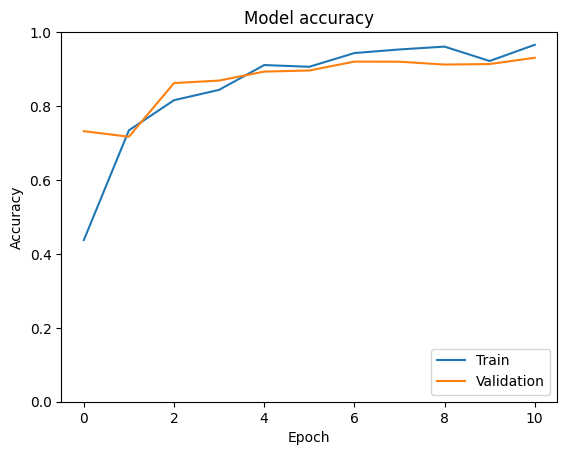

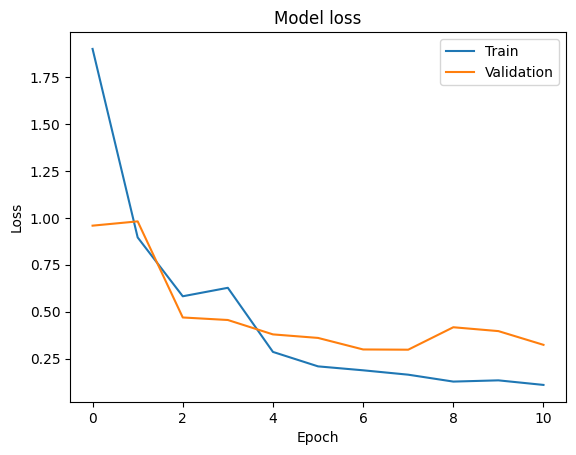

In [21]:
drive.mount('/content/drive')

data_path = '/content/drive/My Drive/Colab Notebooks'

#load pickle
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

#Load data
train_data = load_pickle(os.path.join(data_path, 'train.p'))
validation_data = load_pickle(os.path.join(data_path, 'valid.p'))
test_data = load_pickle(os.path.join(data_path, 'test.p'))

#Prepare data
def prepare_data(data):
    features = data['features']
    labels = data['labels']
    features = features.astype('float32') / 255.0
    return features, labels

X_train, y_train = prepare_data(train_data)
X_val, y_val = prepare_data(validation_data)
X_test, y_test = prepare_data(test_data)

#Convert labels to categorical
num_classes = 43
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

#Alexnet model
def build_alexnet(input_shape, num_classes):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(256, activation='relu'))
    model.add(Dense(256, activation='relu'))
    model.add(Dense(num_classes, activation='softmax'))
    return model

input_shape = (32, 32, 3)
alexnet_model = build_alexnet(input_shape, num_classes)
alexnet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

#Data augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)
datagen.fit(X_train)

#Early stopping
batch_size = 64
epochs = 30

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

history_alexnet = alexnet_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = alexnet_model.evaluate(X_val, y_val, verbose=2)
print(f'Test accuracy: {test_accuracy}')

#plot
plt.plot(history_alexnet.history['accuracy'], label='Train')
plt.plot(history_alexnet.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('Model accuracy')
plt.show()

plt.plot(history_alexnet.history['loss'], label='Train')
plt.plot(history_alexnet.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Model loss')
plt.show()


**code builds, trains, and evaluates a DenseNet model adapted for 32x32 images. It uses data augmentation and early stopping to enhance training and prevent overfitting. The model is compiled with the Adam optimizer and categorical cross-entropy loss. Training history, including accuracy and loss, is plotted for both training and validation sets.**

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Epoch 1/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 736s 1s/step - accuracy: 0.2009 - loss: 2.9490 - val_accuracy: 0.4023 - val_loss: 2.0777
Epoch 2/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.5000 - loss: 1.5381 - val_accuracy: 0.4093 - val_loss: 2.0619
Epoch 3/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 659s 1s/step - accuracy: 0.5954 - loss: 1.2618 - val_accuracy: 0.6197 - val_loss: 1.3445
Epoch 4/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 22s 38ms/step - accuracy: 0.8281 - loss: 0.6584 - val_accuracy: 0.5957 - val_loss: 1.4859
Epoch 5/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 666s 1s/step - accuracy: 0.8140 - loss: 0.5949 - val_accuracy: 0.7590 - val_loss: 0.8722
Epoch 6/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 17s 29ms/step - accuracy: 0.9219 - loss: 0.1953 - val_accuracy: 0.7583 - val_loss: 0.8757
Epoch 7/30
543/543 ━━━━━━━━━━━━━━━━━━━━ 650s 1s/step - accuracy: 0.9047 - loss: 0.3257 - val_a

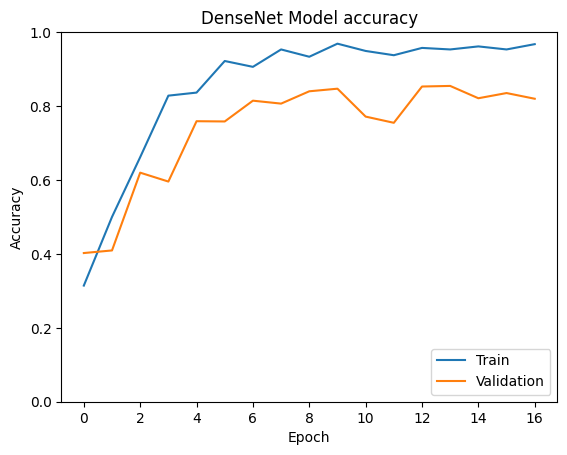

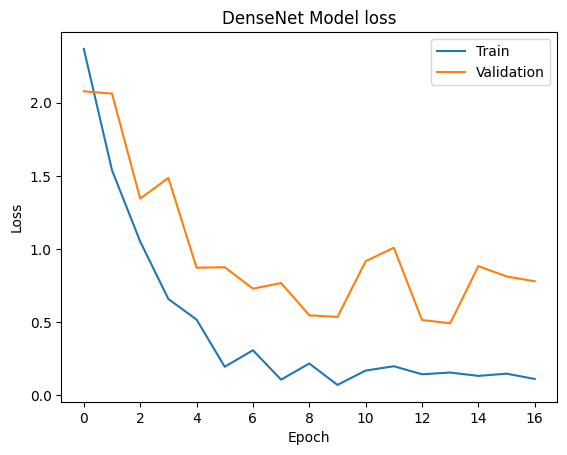

In [22]:
from google.colab import drive
drive.mount('/content/drive')

# Define the path to your data files inside Google Drive
data_path = '/content/drive/My Drive/Colab Notebooks'

# load pickle files
def load_pickle(file_path):
    with open(file_path, 'rb') as f:
        data = pickle.load(f)
    return data

# Load the data
train_data = load_pickle(os.path.join(data_path, 'train.p'))
validation_data = load_pickle(os.path.join(data_path, 'valid.p'))
test_data = load_pickle(os.path.join(data_path, 'test.p'))

#prepare data
def prepare_data(data):
    features = data['features']
    labels = data['labels']
    features = features.astype('float32') / 255.0
    return features, labels

X_train, y_train = prepare_data(train_data)
X_val, y_val = prepare_data(validation_data)
X_test, y_test = prepare_data(test_data)

#onverting labels to categorical
num_classes = 43
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_val = tf.keras.utils.to_categorical(y_val, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)

#define densenet
def build_densenet(input_shape, num_classes):
    base_model = DenseNet121(weights=None, include_top=False, input_shape=input_shape)

    #Add global average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)

    #Add full connected layer
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.5)(x)

    #Add output layer
    predictions = Dense(num_classes, activation='softmax')(x)

    # Create model
    model = Model(inputs=base_model.input, outputs=predictions)

    return model

input_shape = (32, 32, 3)
densenet_model = build_densenet(input_shape, num_classes)
densenet_model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=False
)
datagen.fit(X_train)

#early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train densenet
batch_size = 64
epochs = 30

history_densenet = densenet_model.fit(
    datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=len(X_train) // batch_size,
    validation_data=(X_val, y_val),
    epochs=epochs,
    callbacks=[early_stopping]
)

test_loss, test_accuracy = densenet_model.evaluate(X_val, y_val, verbose=2)
print(f'Test accuracy: {test_accuracy}')

#Plot
plt.plot(history_densenet.history['accuracy'], label='Train')
plt.plot(history_densenet.history['val_accuracy'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')
plt.title('DenseNet Model accuracy')
plt.show()

plt.plot(history_densenet.history['loss'], label='Train')
plt.plot(history_densenet.history['val_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('DenseNet Model loss')
plt.show()


**Plot Training Histories All Together**

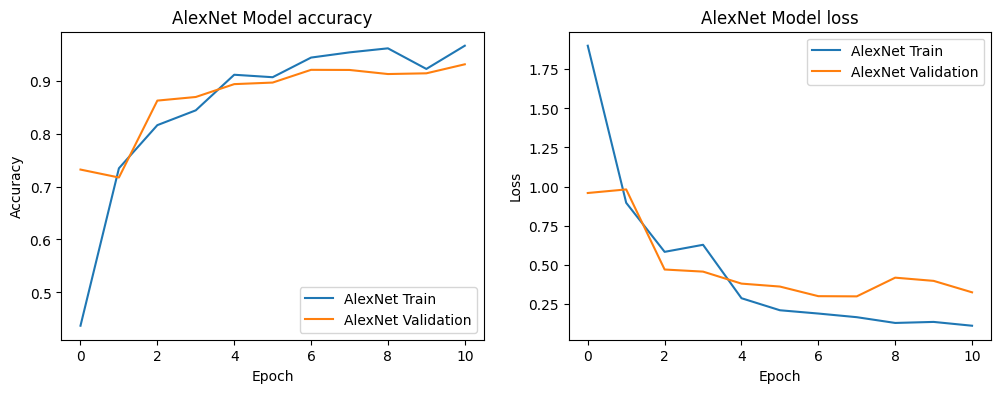

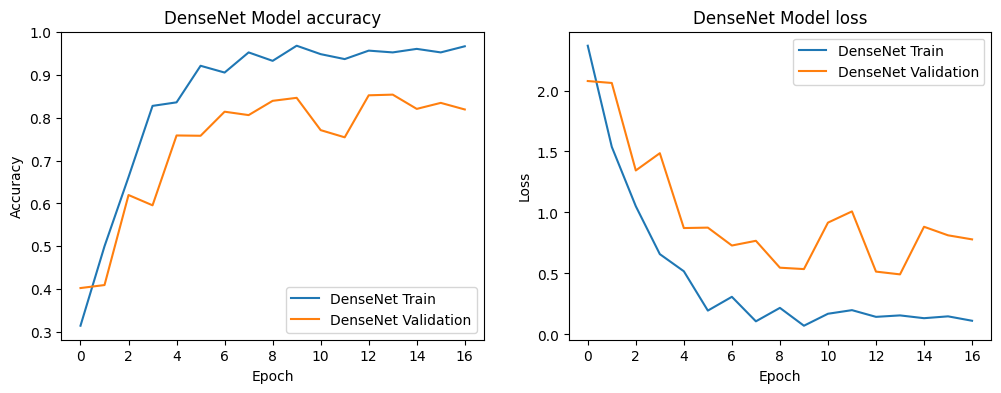

In [23]:
# AlexNet plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_alexnet.history['accuracy'], label='AlexNet Train')
plt.plot(history_alexnet.history['val_accuracy'], label='AlexNet Validation')
plt.title('AlexNet Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_alexnet.history['loss'], label='AlexNet Train')
plt.plot(history_alexnet.history['val_loss'], label='AlexNet Validation')
plt.title('AlexNet Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# DenseNet plot
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_densenet.history['accuracy'], label='DenseNet Train')
plt.plot(history_densenet.history['val_accuracy'], label='DenseNet Validation')
plt.title('DenseNet Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_densenet.history['loss'], label='DenseNet Train')
plt.plot(history_densenet.history['val_loss'], label='DenseNet Validation')
plt.title('DenseNet Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**VGG16 Architecture Diagram**

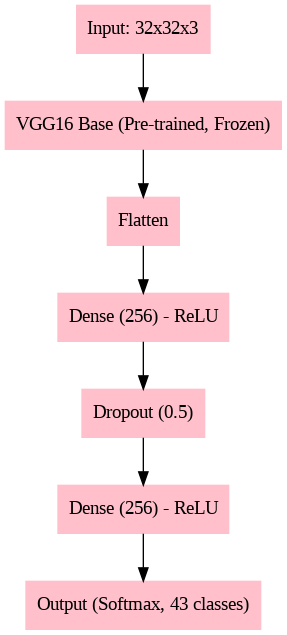

In [26]:
from graphviz import Digraph
from IPython.display import Image, display

# Create a Digraph object for VGG16
vgg16 = Digraph('VGG16', node_attr={'shape': 'box', 'style': 'filled', 'color': 'pink'})

# Define nodes for the VGG16 architecture
vgg16.node('Input', 'Input: 32x32x3')
vgg16.node('VGG16_Base', 'VGG16 Base (Pre-trained, Frozen)')
vgg16.node('Flatten', 'Flatten')
vgg16.node('Dense1', 'Dense (256) - ReLU')
vgg16.node('Dropout1', 'Dropout (0.5)')
vgg16.node('Dense2', 'Dense (256) - ReLU')
vgg16.node('Output', 'Output (Softmax, 43 classes)')

# Define edges as tuples of nodes
edges = [
    ('Input', 'VGG16_Base'),
    ('VGG16_Base', 'Flatten'),
    ('Flatten', 'Dense1'),
    ('Dense1', 'Dropout1'),
    ('Dropout1', 'Dense2'),
    ('Dense2', 'Output')
]

# Add edges to the graph
vgg16.edges(edges)

# Render the VGG16 diagram to a file
vgg16.render('vgg16_architecture', format='png')

# Display the image in the Jupyter Notebook
display(Image(filename='vgg16_architecture.png'))

**AlexNet Architecture Diagram**

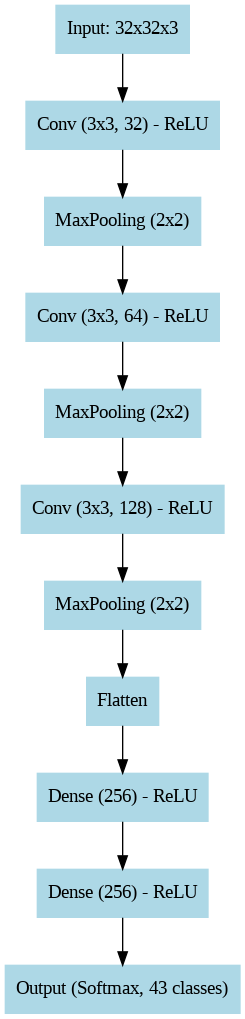

In [27]:
from graphviz import Digraph
from IPython.display import Image, display

# AlexNet Diagram
alexnet = Digraph('AlexNet', node_attr={'shape': 'box', 'style': 'filled', 'color': 'lightblue'})

alexnet.node('Input', 'Input: 32x32x3')
alexnet.node('C1', 'Conv (3x3, 32) - ReLU')
alexnet.node('M1', 'MaxPooling (2x2)')
alexnet.node('C2', 'Conv (3x3, 64) - ReLU')
alexnet.node('M2', 'MaxPooling (2x2)')
alexnet.node('C3', 'Conv (3x3, 128) - ReLU')
alexnet.node('M3', 'MaxPooling (2x2)')
alexnet.node('F', 'Flatten')
alexnet.node('D1', 'Dense (256) - ReLU')
alexnet.node('D2', 'Dense (256) - ReLU')
alexnet.node('O', 'Output (Softmax, 43 classes)')

# Define edges as tuples of nodes
edges = [
    ('Input', 'C1'),
    ('C1', 'M1'),
    ('M1', 'C2'),
    ('C2', 'M2'),
    ('M2', 'C3'),
    ('C3', 'M3'),
    ('M3', 'F'),
    ('F', 'D1'),
    ('D1', 'D2'),
    ('D2', 'O')
]

# Add edges to the graph
alexnet.edges(edges)

# Render the AlexNet diagram to a file
alexnet.render('alexnet_architecture', format='png')

# Display the image in the Jupyter Notebook
display(Image(filename='alexnet_architecture.png'))


**DenseNet Architecture Diagram**

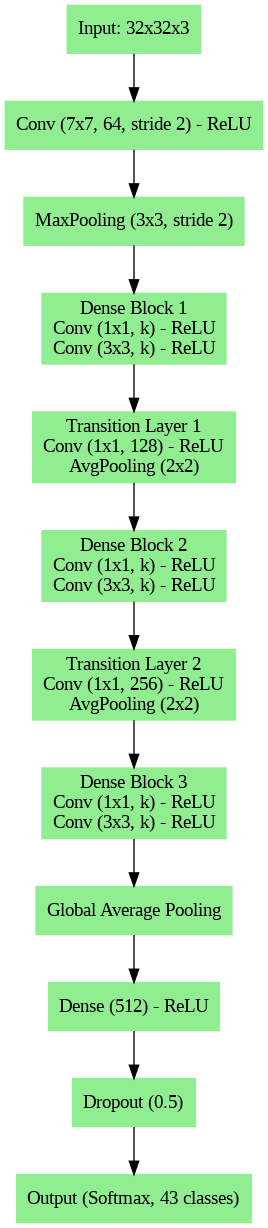

In [28]:
from graphviz import Digraph
from IPython.display import Image, display

# DenseNet Diagram
densenet = Digraph('DenseNet', node_attr={'shape': 'box', 'style': 'filled', 'color': 'lightgreen'})

densenet.node('Input', 'Input: 32x32x3')
densenet.node('C1', 'Conv (7x7, 64, stride 2) - ReLU')
densenet.node('M1', 'MaxPooling (3x3, stride 2)')
densenet.node('DB1', 'Dense Block 1\nConv (1x1, k) - ReLU\nConv (3x3, k) - ReLU')
densenet.node('T1', 'Transition Layer 1\nConv (1x1, 128) - ReLU\nAvgPooling (2x2)')
densenet.node('DB2', 'Dense Block 2\nConv (1x1, k) - ReLU\nConv (3x3, k) - ReLU')
densenet.node('T2', 'Transition Layer 2\nConv (1x1, 256) - ReLU\nAvgPooling (2x2)')
densenet.node('DB3', 'Dense Block 3\nConv (1x1, k) - ReLU\nConv (3x3, k) - ReLU')
densenet.node('GAP', 'Global Average Pooling')
densenet.node('D1', 'Dense (512) - ReLU')
densenet.node('DO', 'Dropout (0.5)')
densenet.node('O', 'Output (Softmax, 43 classes)')

# Define edges as tuples of nodes
edges = [
    ('Input', 'C1'),
    ('C1', 'M1'),
    ('M1', 'DB1'),
    ('DB1', 'T1'),
    ('T1', 'DB2'),
    ('DB2', 'T2'),
    ('T2', 'DB3'),
    ('DB3', 'GAP'),
    ('GAP', 'D1'),
    ('D1', 'DO'),
    ('DO', 'O')
]

# Add edges to the graph
densenet.edges(edges)

# Render the DenseNet diagram to a file
densenet.render('densenet_architecture', format='png')

# Display the image in the Jupyter Notebook
display(Image(filename='densenet_architecture.png'))


**Model Comparison**

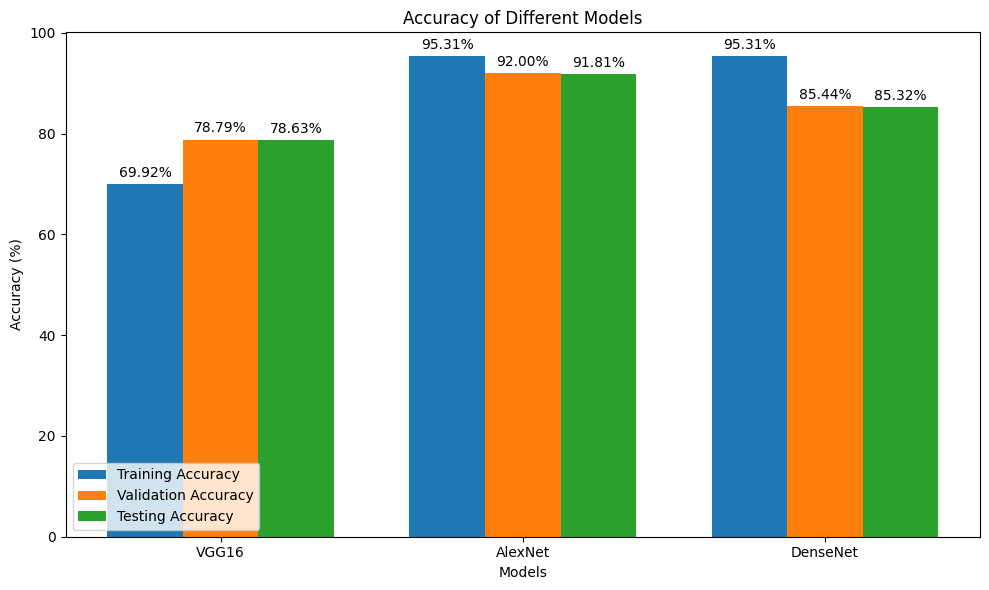

In [29]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['VGG16', 'AlexNet', 'DenseNet']
training_acc = [69.92, 95.31, 95.31]
validation_acc = [78.79, 92.00, 85.44]
testing_acc = [78.63, 91.81, 85.32]

x = np.arange(len(models))  # the label locations
width = 0.25  # the width of the bars

# Create the plot
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width, training_acc, width, label='Training Accuracy')
rects2 = ax.bar(x, validation_acc, width, label='Validation Accuracy')
rects3 = ax.bar(x + width, testing_acc, width, label='Testing Accuracy')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xlabel('Models')
ax.set_ylabel('Accuracy (%)')
ax.set_title('Accuracy of Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(loc='lower left')

# Add data labels above the bars
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.2f}%',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)

fig.tight_layout()

# Show plot
plt.show()

**Time Comparison of Models**

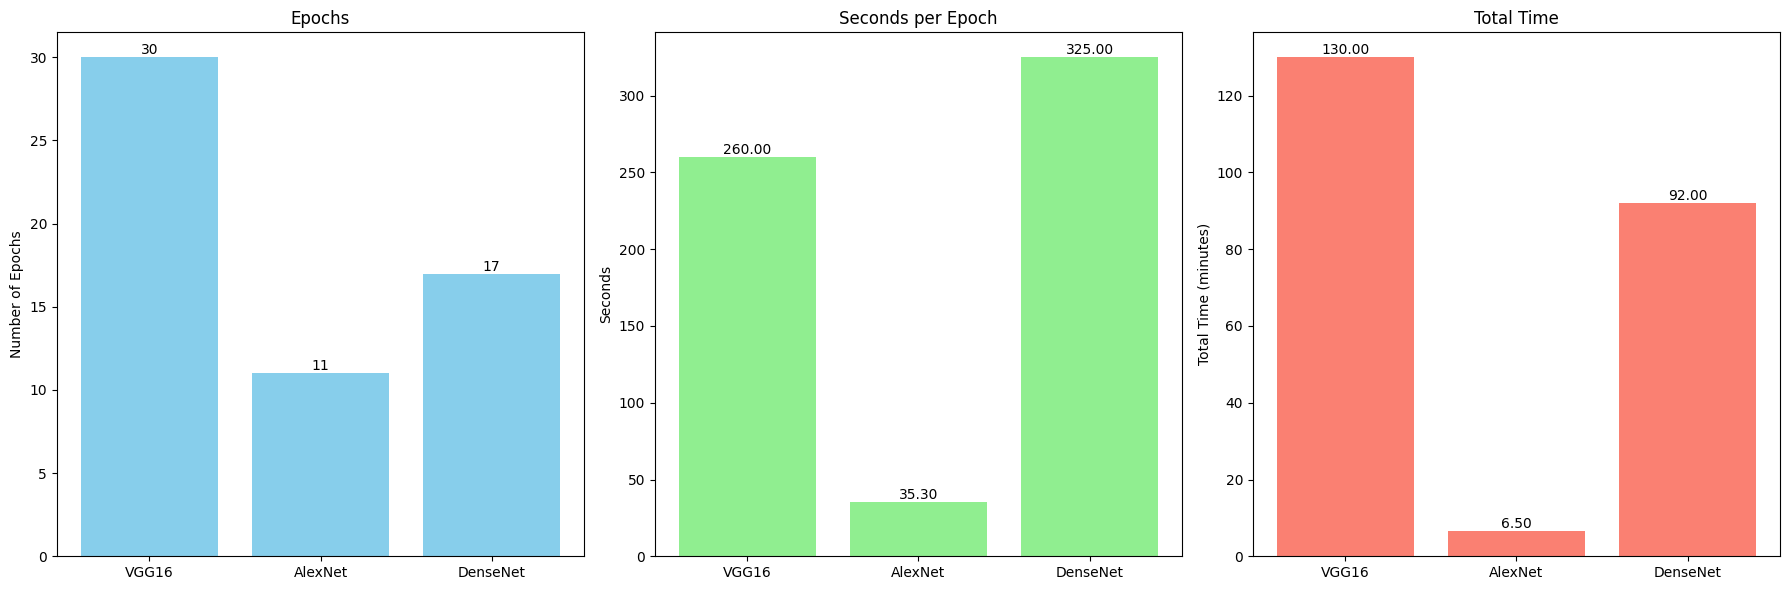

In [32]:
import matplotlib.pyplot as plt
import numpy as np

# Data
models = ['VGG16', 'AlexNet', 'DenseNet']
epochs = [30, 11, 17]
seconds_per_epoch = [260, 35.3, 325]
total_time = [130, 6.5, 92]

# Create subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

# Subplot 1: Epochs
bars1 = axs[0].bar(models, epochs, color='skyblue')
axs[0].set_title('Epochs')
axs[0].set_ylabel('Number of Epochs')
for bar in bars1:
    axs[0].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height()}',
                ha='center', va='bottom')

# Subplot 2: Seconds per Epoch
bars2 = axs[1].bar(models, seconds_per_epoch, color='lightgreen')
axs[1].set_title('Seconds per Epoch')
axs[1].set_ylabel('Seconds')
for bar in bars2:
    axs[1].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
                ha='center', va='bottom')

# Subplot 3: Total Time (minutes)
bars3 = axs[2].bar(models, total_time, color='salmon')
axs[2].set_title('Total Time')
axs[2].set_ylabel('Total Time (minutes)')
for bar in bars3:
    axs[2].text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{bar.get_height():.2f}',
                ha='center', va='bottom')

# Adjust layout
fig.tight_layout()

# Show plot
plt.show()

**F1 Scores and Other Metrics**

In [31]:
from sklearn.metrics import f1_score, classification_report

# Function to evaluate and print F1 score
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = y_pred.argmax(axis=-1)
    y_test_classes = y_test.argmax(axis=-1)
    print(classification_report(y_test_classes, y_pred_classes))
    f1 = f1_score(y_test_classes, y_pred_classes, average='weighted')
    return f1

# Evaluating each model
f1_densenet = evaluate_model(densenet_model, X_test, y_test)
f1_alexnet = evaluate_model(alexnet_model, X_test, y_test)
f1_vgg16 = evaluate_model(vgg16_model, X_test, y_test)

print(f'F1 Score for DenseNet: {f1_densenet}')
print(f'F1 Score for AlexNet: {f1_alexnet}')
print(f'F1 Score for VGG16: {f1_vgg16}')


395/395 ━━━━━━━━━━━━━━━━━━━━ 47s 119ms/step
              precision    recall  f1-score   support

           0       0.85      0.57      0.68        60
           1       0.93      0.91      0.92       720
           2       0.78      0.98      0.86       750
           3       0.95      0.70      0.81       450
           4       0.98      0.85      0.91       660
           5       0.83      0.79      0.81       630
           6       1.00      0.92      0.96       150
           7       0.97      0.51      0.67       450
           8       0.58      0.99      0.73       450
           9       0.78      0.98      0.87       480
          10       0.98      0.96      0.97       660
          11       0.97      0.81      0.89       420
          12       0.97      0.91      0.94       690
          13       0.94      0.99      0.97       720
          14       0.85      1.00      0.92       270
          15       1.00      0.96      0.98       210
          16       0.99      0.90    